![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
#import plotly.tools as tls
import re
#from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
from os import path
import os

<h2> 3.1 Reading data and basic stats </h2>

In [3]:
df = pd.read_csv('train.csv')

print('No of data-points : ',df.shape[0])

No of data-points :  404290


In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

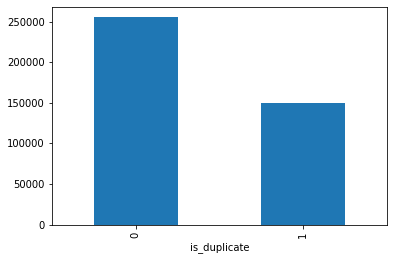

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [7]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [8]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



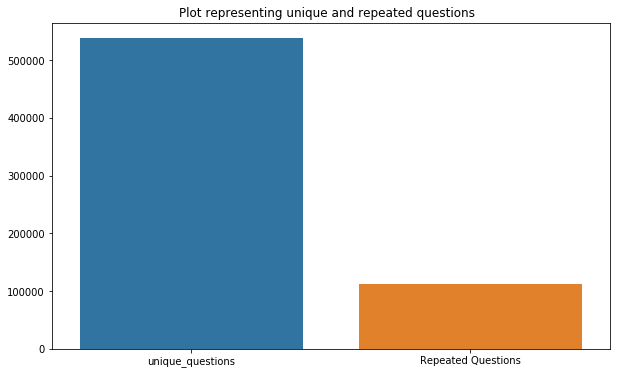

In [10]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [11]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



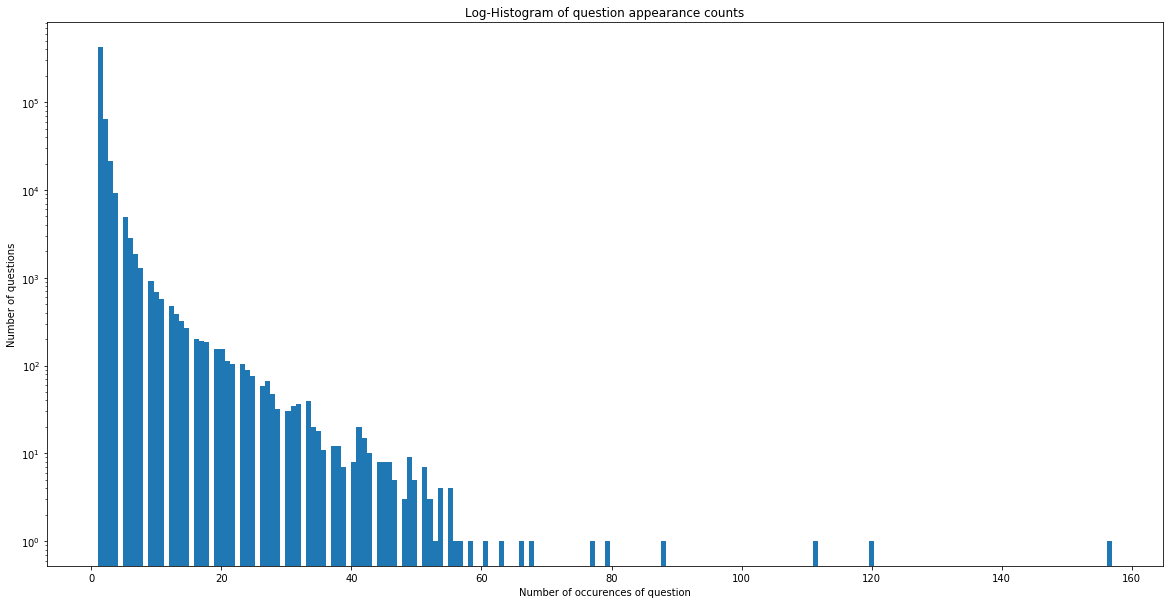

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=200)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [13]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 , one row in ques 1

In [14]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)
df=df.sample(n=100000,random_state=1)
df.to_csv("train.csv")
df.shape

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


(100000, 6)

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [15]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
237030,237030,33086,348102,How can I stop playing video games?,Should I stop playing video games with my child?,0,1,1,35,48,7,9,4.0,16.0,0.250000,2,0
247341,247341,73272,8624,Who is better Donald Trump or Hillary Clinton?,Why is Hillary Clinton a better choice than Do...,1,6,3,46,57,8,10,4.0,18.0,0.222222,9,3
246425,246425,359482,359483,What do you think is the chance that sometime ...,Do you think there will be another world war/n...,1,1,1,139,77,28,14,12.0,39.0,0.307692,2,0
306985,306985,1357,47020,Why are so many questions posted to Quora that...,Why do people write questions on Quora that co...,1,6,7,86,86,16,16,5.0,30.0,0.166667,13,1
225863,225863,334315,334316,Can there even be a movie ever rated 10/10 on ...,What are your 10/10 movies?,0,1,1,51,27,11,5,1.0,16.0,0.062500,2,0


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [16]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 19
Number of Questions with minimum length [question2] : 4


<h4> 3.3.1.1 Feature: word_share </h4>

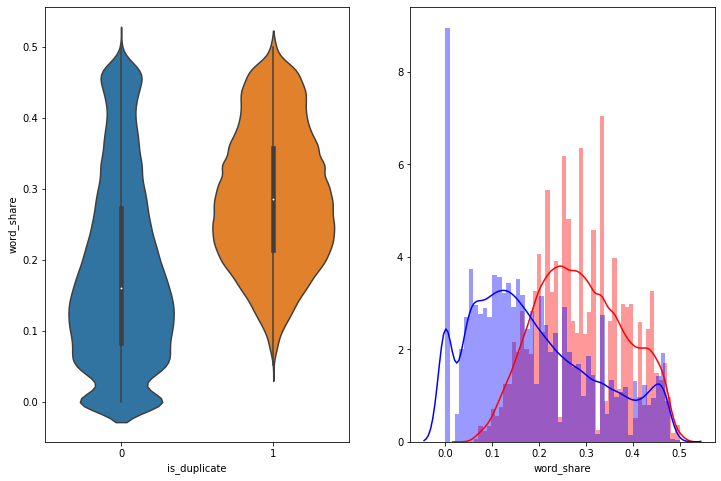

In [17]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

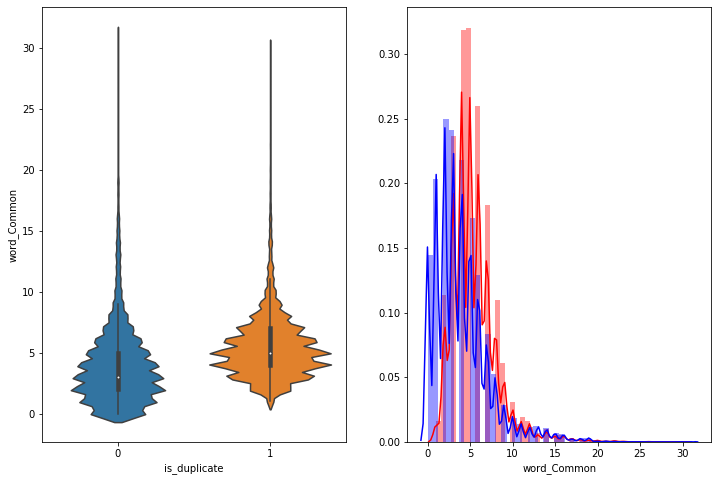

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [19]:
df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df = df.fillna('')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,237030,33086,348102,How can I stop playing video games?,Should I stop playing video games with my child?,0,1,1,35,48,7,9,4.0,16.0,0.250000,2,0
1,247341,73272,8624,Who is better Donald Trump or Hillary Clinton?,Why is Hillary Clinton a better choice than Do...,1,6,3,46,57,8,10,4.0,18.0,0.222222,9,3
2,246425,359482,359483,What do you think is the chance that sometime ...,Do you think there will be another world war/n...,1,1,1,139,77,28,14,12.0,39.0,0.307692,2,0
3,306985,1357,47020,Why are so many questions posted to Quora that...,Why do people write questions on Quora that co...,1,6,7,86,86,16,16,5.0,30.0,0.166667,13,1
4,225863,334315,334316,Can there even be a movie ever rated 10/10 on ...,What are your 10/10 movies?,0,1,1,51,27,11,5,1.0,16.0,0.062500,2,0


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Expanding contractions etc.

In [20]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
        
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
    #temp=x.split()
    #temp= [word for word in temp if word not in STOP_WORDS]
    #print("temp",temp)
    #temp=" ".join(temp)
    #x=temp           
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [21]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [22]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head()

Extracting features for train:
token features...
fuzzy features..


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,237030,237030,33086,348102,how can i stop playing video games,should i stop playing video games with my child,0,0.999975,0.799984,0.333322,...,0.555549,0.0,0.0,2.0,8.0,87,69,72,86,0.777778
1,247341,247341,73272,8624,who is better donald trump or hillary clinton,why is hillary clinton a better choice than do...,1,0.999980,0.833319,0.333322,...,0.599994,0.0,0.0,2.0,9.0,92,83,50,50,0.361702
2,246425,246425,359482,359483,what do you think is the chance that sometime ...,do you think there will be another world war n...,1,0.857131,0.499996,0.999986,...,0.464284,0.0,0.0,13.0,21.5,94,70,51,60,0.294872
3,306985,306985,1357,47020,why are so many questions posted to quora that...,why do people write questions on quora that co...,1,0.374995,0.333330,0.333328,...,0.312498,0.0,1.0,0.0,16.0,65,56,58,58,0.137931
4,225863,225863,334315,334316,can there even be a movie ever rated 10 10 on ...,what are your 10 10 movies,0,0.499975,0.166664,0.000000,...,0.083333,0.0,0.0,6.0,9.0,46,50,42,52,0.250000


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [23]:
import csv

df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print(type(p))

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file

#np.savetxt('train_p.txt', p, delimiter=' ', fmt='"%s"')
#np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

with open('train_p.txt', 'w', encoding = 'utf-8') as f:
    csv.writer(f).writerows(p)

with open('train_n.txt', 'w', encoding = 'utf-8') as f:
    csv.writer(f).writerows(n)

<class 'numpy.ndarray'>
Number of data points in class 1 (duplicate pairs) : 73876
Number of data points in class 0 (non duplicate pairs) : 126124


In [24]:
# reading the text files and obtaining length

d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'), encoding = 'utf-8').read()
textn_w = open(path.join(d, 'train_n.txt'), encoding = 'utf-8').read()
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 7910840
Total number of words in non duplicate pair questions : 16277812


<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

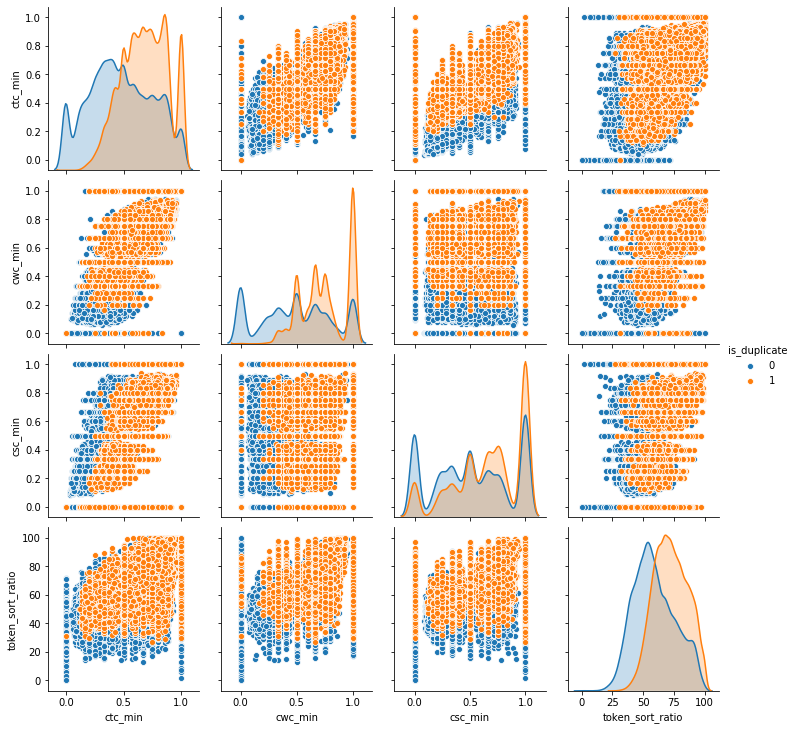

In [25]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

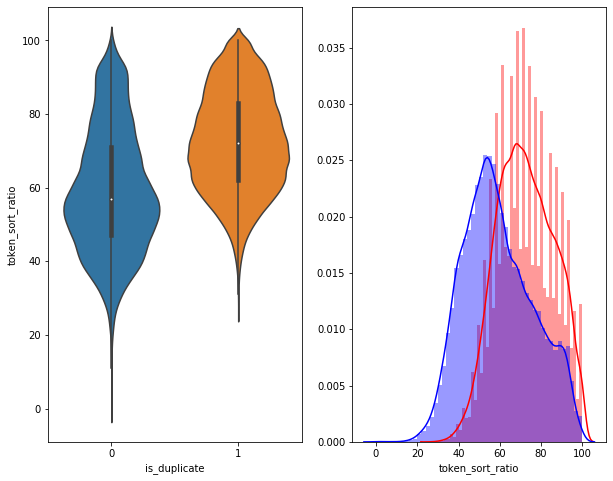

In [26]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

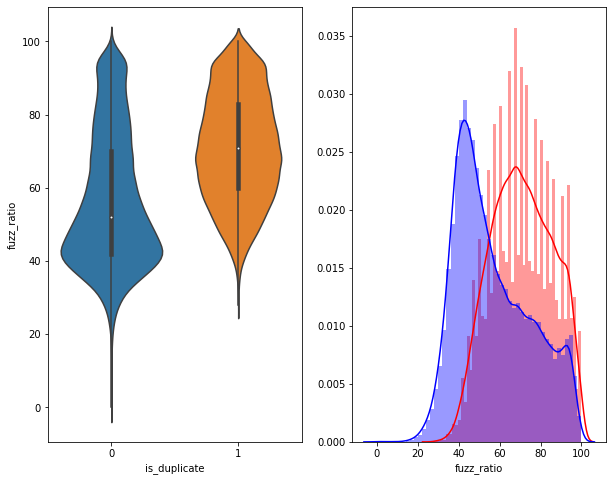

In [27]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [28]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [29]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.047s...
[t-SNE] Computed neighbors for 5000 samples in 0.628s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.140983
[t-SNE] Computed conditional probabilities in 0.438s
[t-SNE] Iteration 50: error = 82.7892609, gradient norm = 0.0468319 (50 iterations in 3.167s)
[t-SNE] Iteration 100: error = 70.7630463, gradient norm = 0.0113241 (50 iterations in 2.505s)
[t-SNE] Iteration 150: error = 69.0387039, gradient norm = 0.0055737 (50 iterations in 2.444s)
[t-SNE] Iteration 200: error = 68.3265839, gradient norm = 0.0046528 (50 iterations in 2.379s)
[t-SNE] Iteration 250: error = 67.9058838, gradient norm = 0.0029349

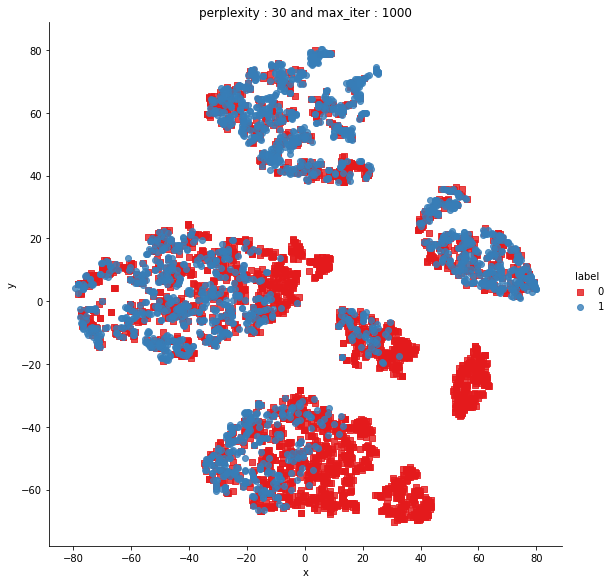

In [30]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [31]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.055s...
[t-SNE] Computed neighbors for 5000 samples in 0.666s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.140983
[t-SNE] Computed conditional probabilities in 0.383s
[t-SNE] Iteration 50: error = 83.5258026, gradient norm = 0.0362758 (50 iterations in 10.134s)
[t-SNE] Iteration 100: error = 70.1170425, gradient norm = 0.0044234 (50 iterations in 6.248s)
[t-SNE] Iteration 150: error = 68.5640335, gradient norm = 0.0018357 (50 iterations in 6.591s)
[t-SNE] Iteration 200: error = 68.0000305, gradient norm = 0.0012145 (50 iterations in 4.720s)
[t-SNE] Iteration 250: error = 67.6575775, gradient norm = 0.001049

In [32]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [33]:
from tqdm import tqdm
import spacy

In [34]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,237030,237030,33086,348102,How can I stop playing video games?,Should I stop playing video games with my child?,0
1,247341,247341,73272,8624,Who is better Donald Trump or Hillary Clinton?,Why is Hillary Clinton a better choice than Do...,1
2,246425,246425,359482,359483,What do you think is the chance that sometime ...,Do you think there will be another world war/n...,1
3,306985,306985,1357,47020,Why are so many questions posted to Quora that...,Why do people write questions on Quora that co...,1
4,225863,225863,334315,334316,Can there even be a movie ever rated 10/10 on ...,What are your 10/10 movies?,0


In [35]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [36]:
df1=df1.drop('Unnamed: 0',axis=1)
df3 = df3.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df3
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id']=df1['id']
new_df['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left') #merging df1 and df2
X  = final_df.merge(new_df, on='id',how='left')#merging final_df and new_df

In [37]:
#removing id from X
X=X.drop('id',axis=1)
X.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [38]:
y=np.array(duplicate)

In [39]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)

In [40]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(70000, 27)
(70000,)
(30000, 27)
(30000,)


In [41]:
#seperating questions for tfidf vectorizer
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer

# list_of_sentance_train=[]
# for sentance in X_train_ques:
#     list_of_sentance_train.append(sentance.split())

tfidf = TfidfVectorizer(lowercase=False )
tfidf.fit_transform(X_train_ques)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [43]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#for train dataset

#from spacy import en_core_web_sm

nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train_ques)):
    doc1 = nlp(qu1) 
    # 384,96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
#df['q1_feats_m'] = list(vecs1)


100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [24:15<00:00, 48.10it/s]


In [44]:
vecs2 = []
for qu2 in tqdm(list(X_test_ques)):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
#df['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [11:07<00:00, 44.94it/s]


In [45]:
first_df=pd.DataFrame(vecs1)
sec_df=pd.DataFrame(vecs2)

In [46]:
from scipy.sparse import hstack
X_train = hstack((X_train.values,first_df))
X_test= hstack((X_test.values,sec_df))
print(X_train.shape)
print(X_test.shape)

(70000, 122)
(30000, 122)


In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import Counter
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
#from sklearn import model_selection
#from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

<h1>4. Machine Learning Models </h1>

In [48]:

print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 122)
Number of data points in test data : (30000, 122)


In [49]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6313714285714286 Class 1:  0.3686285714285714
---------- Distribution of output variable in test data ----------
Class 0:  0.6288666666666667 Class 1:  0.3711333333333333


In [50]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5113776855796034
For values of alpha =  0.0001 The log loss is: 0.5239115163800464
For values of alpha =  0.001 The log loss is: 0.5210109375858811
For values of alpha =  0.01 The log loss is: 0.5115935217883222
For values of alpha =  0.1 The log loss is: 0.5083080618013692
For values of alpha =  1 The log loss is: 0.5353978626445822
For values of alpha =  10 The log loss is: 0.5696071477316893


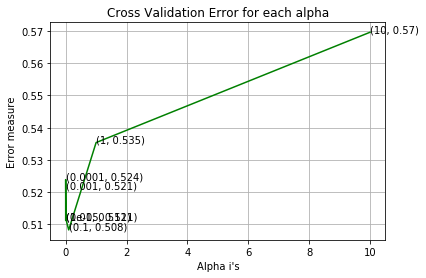

For values of best alpha =  0.1 The train log loss is: 0.5017198215119699
For values of best alpha =  0.1 The test log loss is: 0.5083080618013692
Total number of data points : 30000


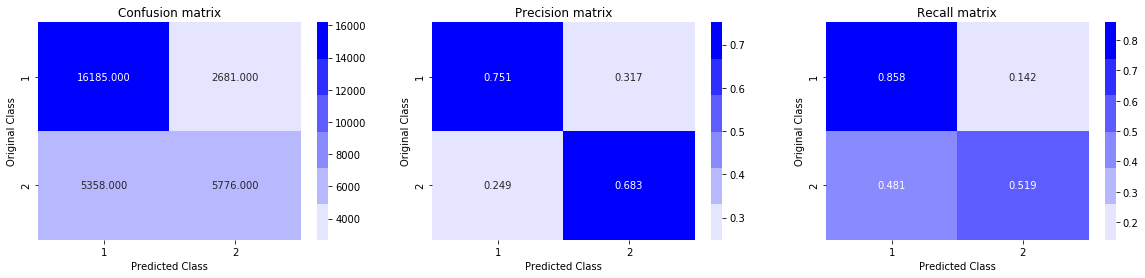

In [51]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)#it returns index of min elemen
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6595693700578819
For values of alpha =  0.0001 The log loss is: 0.5440237744691562
For values of alpha =  0.001 The log loss is: 0.5371240442199843
For values of alpha =  0.01 The log loss is: 0.5418090872155094
For values of alpha =  0.1 The log loss is: 0.5459862889392414
For values of alpha =  1 The log loss is: 0.6595693700578819
For values of alpha =  10 The log loss is: 0.6595693700578819
For values of alpha =  100 The log loss is: 0.6595693700578819
For values of alpha =  1000 The log loss is: 0.6595695711205344


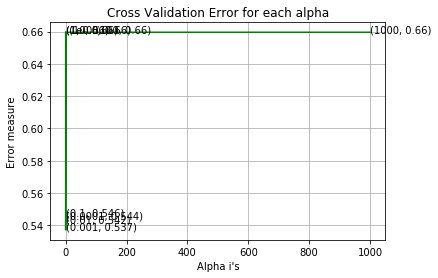

For values of best alpha =  0.001 The train log loss is: 0.5306487900756361
For values of best alpha =  0.001 The test log loss is: 0.5371240442199843
Total number of data points : 30000


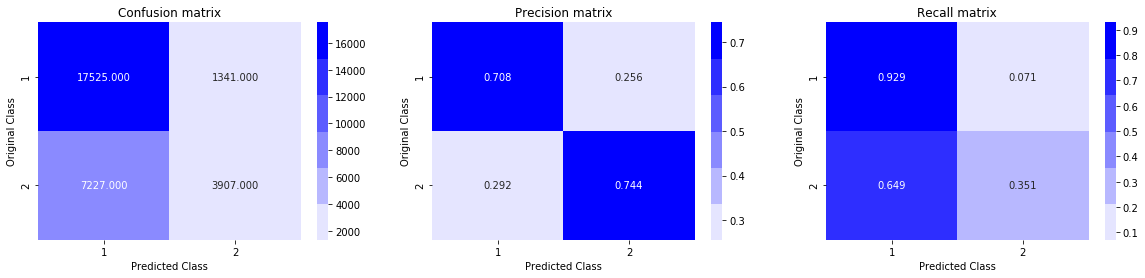

In [52]:
alpha = [10 ** x for x in range(-5, 4)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [53]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

#xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685555	valid-logloss:0.685592
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.623226	valid-logloss:0.623835
[20]	train-logloss:0.577848	valid-logloss:0.578775
[30]	train-logloss:0.54374	valid-logloss:0.544906
[40]	train-logloss:0.517574	valid-logloss:0.518981
[50]	train-logloss:0.497078	valid-logloss:0.498741
[60]	train-logloss:0.480666	valid-logloss:0.482599
[70]	train-logloss:0.467487	valid-logloss:0.469566
[80]	train-logloss:0.457097	valid-logloss:0.459294
[90]	train-logloss:0.448537	valid-logloss:0.450962
[100]	train-logloss:0.441554	valid-logloss:0.444139
[110]	train-logloss:0.43535	valid-logloss:0.438125
[120]	train-logloss:0.430142	valid-logloss:0.433131
[130]	train-logloss:0.425817	valid-logloss:0.429061
[140]	train-logloss:0.421816	valid-logloss:0.425218
[150]	train-logloss:0.418517	valid-logloss:0.422152
[160]	train-logloss:0.415442	v

Total number of data points : 30000


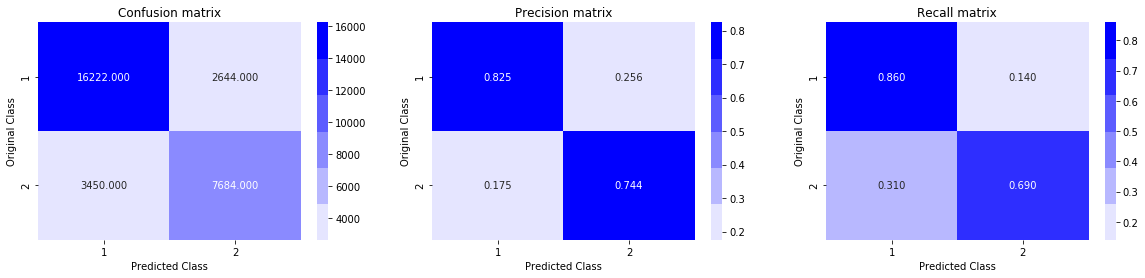

In [54]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>For TFIDF features</h2>

In [55]:
dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [56]:
df1=df1.drop('Unnamed: 0',axis=1)
df3 = df3.fillna(' ')
#assigning new dataframe with columns question(q1+q2) and id same as df3
new_df = pd.DataFrame()
new_df['questions'] = df3.question1 + ' ' + df3.question2
new_df['id'] = df3.id
df2['id']=df1['id']
new_df['id']=df1['id']
final_df = df1.merge(df2, on='id',how='left') #merging df1 and df2
X  = final_df.merge(new_df, on='id',how='left')#merging final_df and new_df

In [57]:
#removing id from X
X=X.drop('id',axis=1)
X.columns

Index(['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'questions'],
      dtype='object')

In [58]:
y=np.array(duplicate)

In [59]:
#splitting data into train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=3,test_size=0.3)

In [60]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(70000, 27)
(70000,)
(30000, 27)
(30000,)


In [61]:
#seperating questions for tfidf vectorizer
X_train_ques=X_train['questions']
X_test_ques=X_test['questions']

X_train=X_train.drop('questions',axis=1)
X_test=X_test.drop('questions',axis=1)


In [62]:
#tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3),min_df=10)
X_train_tfidf=tf_idf_vect.fit_transform(X_train_ques)
X_test_tfidf=tf_idf_vect.transform(X_test_ques)


In [63]:
#adding tfidf features to our train and test data using hstack
X_train = hstack((X_train.values,X_train_tfidf))
X_test= hstack((X_test.values,X_test_tfidf))
print(X_train.shape)
print(X_test.shape)

(70000, 29464)
(30000, 29464)


In [64]:
# #standardising data
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler(with_mean=False)
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

<h3>Applying Logistic Regression</h3>

For values of alpha =  1e-05 The log loss is: 0.45374198182724007
For values of alpha =  0.0001 The log loss is: 0.4457321502713983
For values of alpha =  0.001 The log loss is: 0.4671963113411843
For values of alpha =  0.01 The log loss is: 0.49120140674480667
For values of alpha =  0.1 The log loss is: 0.5139923511538357
For values of alpha =  1 The log loss is: 0.5414478796116782
For values of alpha =  10 The log loss is: 0.5892747122151001
For values of alpha =  100 The log loss is: 0.6095606175503483


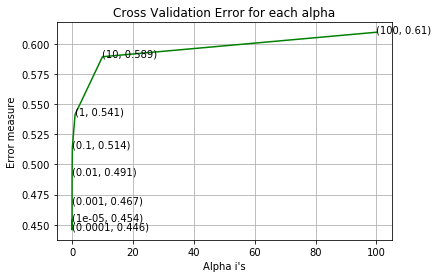

For values of best alpha =  0.0001 The train log loss is: 0.43978998786412477
For values of best alpha =  0.0001 The test log loss is: 0.4457321502713983
Total number of data points : 30000


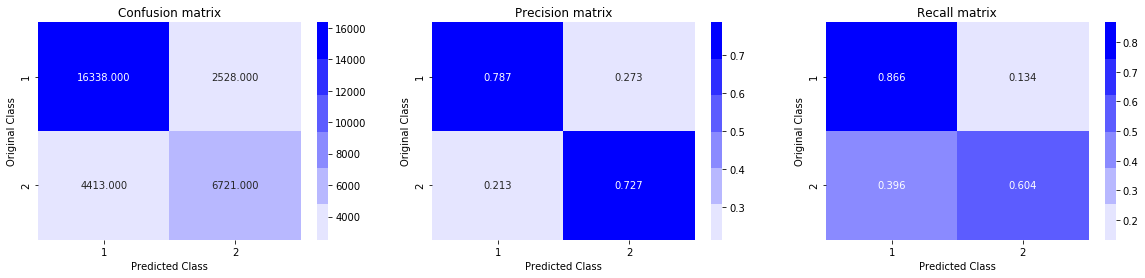

In [65]:
alpha = [10 ** x for x in range(-5, 3)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h3>Applying Linear SVM</h3>

For values of alpha =  1e-05 The log loss is: 0.4769884707446452
For values of alpha =  0.0001 The log loss is: 0.4997825814930422
For values of alpha =  0.001 The log loss is: 0.5134536692535302
For values of alpha =  0.01 The log loss is: 0.5093787677846822
For values of alpha =  0.1 The log loss is: 0.5357661150302225
For values of alpha =  1 The log loss is: 0.6395582799193483
For values of alpha =  10 The log loss is: 0.6448107977489821
For values of alpha =  100 The log loss is: 0.6595695711205344
For values of alpha =  1000 The log loss is: 0.6595695711205344


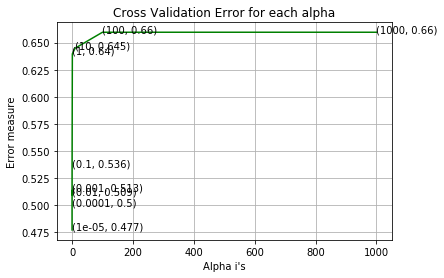

For values of best alpha =  1e-05 The train log loss is: 0.4699773943671304
For values of best alpha =  1e-05 The test log loss is: 0.4769884707446452
Total number of data points : 30000


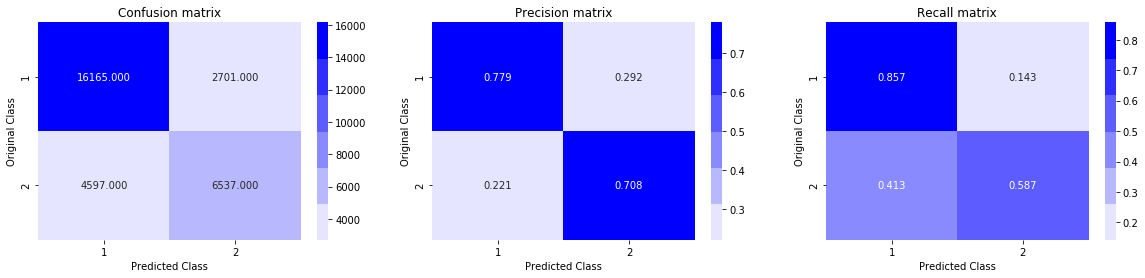

In [66]:
alpha = [10 ** x for x in range(-5, 4)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h3>XGBOOST</h3>

In [67]:
import xgboost as xgb

In [68]:
n_estimators = [50,100,150,200,300,400,500]
test_scores = []
train_scores = []
for i in n_estimators:
    clf = xgb.XGBClassifier(learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, y_pred, eps=1e-15)
    train_scores.append(log_loss_train)
    y_pred = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, y_pred, eps=1e-15)
    test_scores.append(log_loss_test)
    print('For n_estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)

For n_estimators =  50 Train Log Loss  0.41114195049019264 Test Log Loss  0.4140228859537747
For n_estimators =  100 Train Log Loss  0.3897383424027715 Test Log Loss  0.3949488021223864
For n_estimators =  150 Train Log Loss  0.3787731771535053 Test Log Loss  0.3865066323426421
For n_estimators =  200 Train Log Loss  0.37156678165931945 Test Log Loss  0.38188131214546833
For n_estimators =  300 Train Log Loss  0.3592424687229733 Test Log Loss  0.3736179119328545
For n_estimators =  400 Train Log Loss  0.35059374651469555 Test Log Loss  0.3694904881025918
For n_estimators =  500 Train Log Loss  0.34252650794828327 Test Log Loss  0.3651387075353528


The test log loss is: 0.3651387075353528


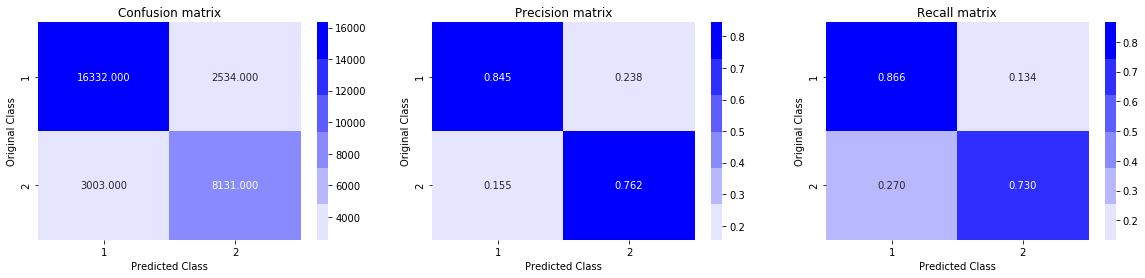

In [69]:
clf=xgb.XGBClassifier(learning_rate=0.1,n_estimators=500,n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, y_pred, eps=1e-15))
predicted_y =np.argmax(y_pred,axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Procedure and Observation

1) First we did Exploratory Data Analysis on Quora Question Pair data in which we performed such as finding number of different questions, checking for duplicates, number of occurence of questions etc.
2) Then we performed some feature extraction like fuzz ratio, fuzz partial ration, longest common substring etc.
3) After performing feature extraction we applied some visualisation techniques such as pair-plot, violin plot, TSNE etc.
4) Then we peformed tfidf-w2vec vectorizer on pair of questions dataset and then we merged each tfidf-w2vec vectors to our advanced featured vectors.
5) In the next step we applied some machine learning algorithm such as logistic regression, support vector machines etc and found log-loss for both train and test dataset.
6) After choosing best parameters we then plotted confusion matrix, precision matrix and recall matrix for each one.
7) we did same process for tfidf vectorizer at the end of this project.

In [3]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","log loss"]
x.add_row(['Logistic regression','TFIDF w2vec','0.508'])
x.add_row(['Linear SVM','TFIDF w2vec','0.537'])
x.add_row(['XGBOOST','TFIDF w2vec','0.390'])
x.add_row(['Logistic regression','TFIDF ','0.445'])
x.add_row(['Linear SVM','TFIDF','0.476'])
x.add_row(['XGBOOST','TFIDF ','0.365'])

print(x)

+---------------------+-------------+----------+
|        Model        |  vectorizer | log loss |
+---------------------+-------------+----------+
| Logistic regression | TFIDF w2vec |  0.508   |
|      Linear SVM     | TFIDF w2vec |  0.537   |
|       XGBOOST       | TFIDF w2vec |  0.390   |
| Logistic regression |    TFIDF    |  0.445   |
|      Linear SVM     |    TFIDF    |  0.476   |
|       XGBOOST       |    TFIDF    |  0.365   |
+---------------------+-------------+----------+
